# Gapfilling Observations with Synthetic data

## Create no-gaps datasets

In [1]:
import folium
import numpy as np
import xarray as xr
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import odc.geo.xr
from odc.geo.xr import assign_crs
import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _collect_prediction_data import round_coords

In [2]:
model_var='NDVI'
feat = 'CLIM'
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

In [3]:
yy = xr.open_dataset(f'{base}synthetic/{model_var}/{model_var}_{feat}_synthetic_5km_monthly_1982_2022.nc')
obs = xr.open_dataset(f'{base}{model_var}_harmonization/LGBM/{model_var}_{feat}_LGBM_5km_monthly_1982_2022_wGaps.nc')

if model_var=='LST':
    yy = yy-273.15
    obs = obs-273.15

obs = obs.sel(time=yy.time)

### Gapfill small gaps with linear interpolation

In [4]:
# seperate into climatologies and anomalies
obs_monthly = obs.groupby('time.month').mean()
obs_anom = obs.groupby('time.month') - obs_monthly  

# fill linearly by one-step
obs_anom = obs_anom.interpolate_na(dim='time', method='linear', limit=1)

#recombine anomalies and climatology
obs_fill = obs_anom.groupby('time.month') + obs_monthly
obs_fill = assign_crs(obs_fill.drop('month'), crs='epsg:4326')

### Fill remaining data-gaps with synthetic data

In [5]:
syn_fill = obs_fill.fillna(yy[model_var])

## Save to disk

In [6]:
#export here for the carbon flux modelling
syn_fill.to_netcdf(base+'5km/'+model_var+'_5km_monthly_1982_2022.nc')

In [7]:
#export here for publication
syn_fill.to_netcdf(f'{base}{model_var}_harmonization/LGBM/{model_var}_{feat}_LGBM_5km_monthly_1982_2022_noGaps.nc')

## Create a Aus-wide timeseries plot

With rainfall anomalies

In [8]:
rain = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_5km_monthly_1981_2022.nc').rain
rain_clim_std = rain.sel(time=slice('1982', '2012')).groupby('time.month').std().compute()
rain_clim_mean = rain.sel(time=slice('1982', '2012')).groupby('time.month').mean().compute()

#standardized anom
def stand_anomalies(ds, clim_mean, clim_std):
    std_anom = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
    ds.compute().groupby("time.month"),
    clim_mean, clim_std)
    return std_anom

rain_std_anom = stand_anomalies(rain, rain_clim_mean, rain_clim_std)

rain_df = rain_std_anom.rename('rain').sel(time=slice('1982', '2022')).rolling(time=3,
                min_periods=1).mean().mean(['latitude','longitude']).to_dataframe().drop(['spatial_ref', 'month'], axis=1)

/jobfs/100438890.gadi-pbs/ipykernel_813918/3286925957.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.8, pad=0.01)


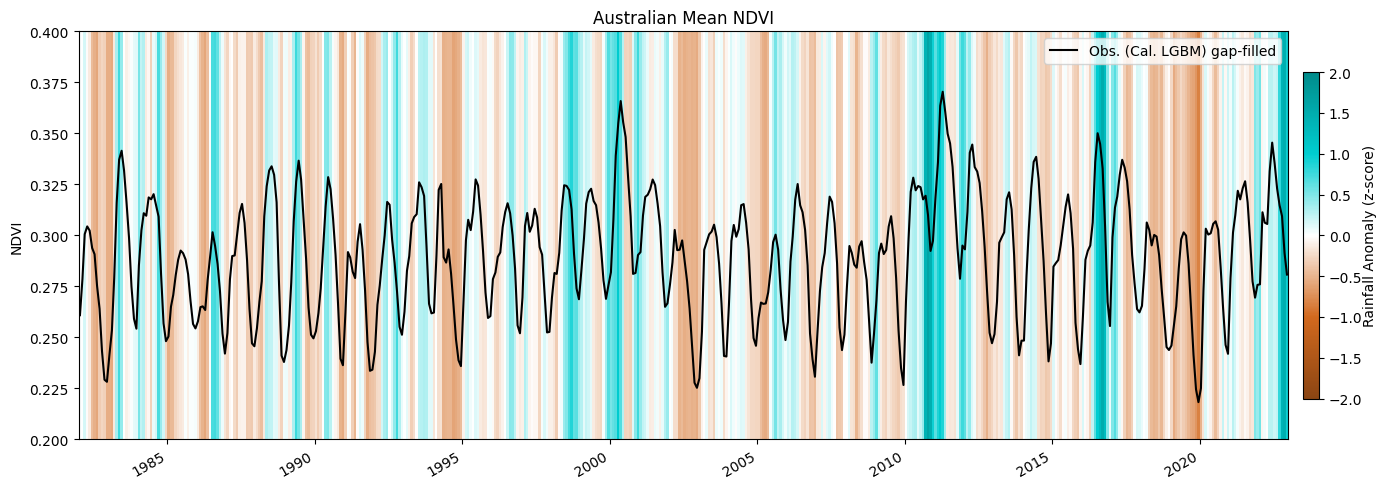

In [11]:
fig, ax = plt.subplots(1,1, figsize=(18,6))
ax2 = ax.twinx()
# .rolling(time=3, min_periods=1).mean()
# obs[model_var].mean(['latitude','longitude']).plot(ax=ax, label='Obs. (Cal. LGBM) with gaps', c='red')
# yy[model_var].mean(['latitude','longitude']).plot(ax=ax, label='Synthetic', c='green')
syn_fill[model_var].mean(['latitude','longitude']).plot(ax=ax, label='Obs. (Cal. LGBM) gap-filled', c='black')

norm=plt.Normalize(-2,2)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['saddlebrown','chocolate','white','darkturquoise','darkcyan'], N=256)

# Plot bars
bar = ax2.bar(rain_df.index, 1, color=cmap(norm(rain_df['rain'])), width=32)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8, pad=0.01)
cbar.set_label('Rainfall Anomaly (z-score)',labelpad=.5)

ax2.set_zorder(ax.get_zorder()-1)
ax.set_frame_on(False)

# Reformat y-axis label and tick labels
ax.set_ylabel(model_var)
ax.set_xlabel('')
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_ylim([0, 1]) 
ax.margins(x=0)

# Adjust the margins around the plot area
plt.subplots_adjust(left=0.1, right=None, top=None, bottom=0.2, wspace=None, hspace=None)

if model_var=='NDVI':
    ax.set_ylim(0.20, 0.40)

ax.legend()
ax.set_title('Australian Mean '+model_var);
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/Australian_"+model_var+"_rollingmean.png",
            bbox_inches='tight', dpi=300)

## Animations

In [ ]:
import sys
sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.plotting import xr_animation
from IPython.display import Image

In [ ]:
# # Produce time series animation
# path = '/g/data/os22/chad_tmp/climate-carbon-interactions/results/gifs/'+model_var+'_observed.gif'
# path = '/g/data/os22/chad_tmp/climate-carbon-interactions/results/gifs/'+model_var+'_synthetic_LGBM.gif'
path = '/g/data/os22/chad_tmp/climate-carbon-interactions/results/gifs/'+model_var+'_gapfilled_LGBM.gif'

if model_var=='NDVI':
    cmap='gist_earth_r'
    vmin=0.1
    vmax=0.8

if model_var=='LST':
    cmap='inferno'
    vmin=5
    vmax=45

xr_animation(
             # ds=obs.sel(time=slice('1982','2001')).rolling(time=2, min_periods=1).mean(), 
             # ds=yy.sel(time=slice('1982','2001')).rolling(time=2, min_periods=1).mean(), 
             syn_fill.sel(time=slice('1982','2001')).rolling(time=2, min_periods=1).mean(), 
             output_path=path,
             bands=[model_var],  
             show_date='%B-%Y',
             show_text=model_var,
             interval=150,
             imshow_kwargs={'cmap': cmap, 'vmin': vmin, 'vmax': vmax},
             colorbar_kwargs={'colors': 'black'},
             # width_pixels=300,
             annotation_kwargs= {'color':'black', 'animated': True}
    ) 

# Plot animated gif
plt.close()
Image(filename=path)